In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 8/1/2021 QAAFI UQ
# Code functionalities:
# In order to study the interactions between G and M under different climate conditions, climate zones
# can be created by kmeans clustering (Arthur and Vassilvitskii, 2007). The clustering is applied separately 
# to average mean daily temperature, sum solar radiation and rainfall during the crop growing season.

#Arthur, D., Vassilvitskii, S., 2007. k-means + +: the advantages of careful seeding.
#In: Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete
#Algorithms Society for Industrial and Applied Mathematics, New Orleans,
#Louisiana, pp. 1027–1035.
#####################################################################################################################

In [1]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



<ipython-input-1-ff2a89263e65>:28: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [78]:
#Read mean created using nco from Linux
#data0 = xr.open_dataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\mean.nc', decode_times=False)

#Read output from psims
data00 = xr.open_dataset(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run015/output.nc4', decode_times=False) 

# replace all values equal to -99 with np.nan
#data_mean = data0.where(data0['biomass'] != -99.)
dataPre4 = data00.where(data00['biomass'] > 2693.5250244140625) #df.biomass.quantile(0.005)
dataPre3 = dataPre4.where(dataPre4['FloweringDAS'] != -99.)

#Remove lat and lon combinations that were outside the study area. For this we need to convert the xarray to a 2D dataframe
#Conver multidimendional frame to 2D frame
data = dataPre3.to_dataframe()
data.reset_index(drop=False, inplace=True)

df = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\SorghumMask\OutsideAreas.csv')
coordinate_list = [list(row) for row in df.values]

dropSet = {tuple(elem) for elem in coordinate_list}
# Creates a multi-index on letter/colour.
temp = data.set_index(['lat', 'lon'])
# Keep all elements of the index except those in droplist.
temp = temp.loc[list(set(temp.index) - dropSet)]
# Reset index to get the original column layout.
df_dropped = temp.reset_index()
dfc = df_dropped[df_dropped.biomass != 0]

#Change name of column
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()
df0 = df.where(df['biomass'] != 0)

X=df0.groupby(['lat','lon'])[['rad40DAS','rad80DAS','radHarv','rain40DAS','rain80DAS','rainHarv','temp40DAS','temp80DAS','tempHarv','biomass']].mean()

In [79]:
X

rad40DAS    rad80DAS     radHarv   rain40DAS   rain80DAS  \
lat   lon                                                                  
25.25 -81.25  940.741821  892.229553  794.801208  235.732605  204.895905   
      -80.75  851.104553  830.807312  738.552246  284.264984  210.999130   
25.75 -81.75  962.600525  895.567871  799.576477  245.178665  240.116806   
      -81.25  923.276917  865.237183  774.140564  304.176910  261.682220   
      -80.75  824.786438  796.616089  711.153442  321.432739  259.580261   
...                  ...         ...         ...         ...         ...   
48.75 -93.75  823.937500  825.055298  614.686707  141.730225  119.244598   
      -93.25  821.462708  820.895142  613.326660  138.128433  119.297607   
      -92.75  822.718018  822.248901  615.610535  136.681198  125.872643   
49.25 -95.25  834.811157  836.851074  617.445740  135.285431  116.968925   
      -94.75  834.735596  835.574097  618.078125  131.501740  113.982758   

                rainHarv  temp40DAS  temp80DAS   tempHarv       biomass  
lat   lon                                                                
25.25 -81.25  252.141693  28.254566  29.002132  28.768867  19052.826172  
      -80.75  283.334900  27.710733  28.523867  28.350399  17342.443359  
25.75 -81.75  273.922211  28.151400  28.857300  28.719933  19231.335938  
      -81.25  293.346680  27.578701  28.500334  28.430401  18387.492188  
      -80.75  295.166138  27.422867  28.527866  28.438868  16668.882812  
...                  ...        ...        ...        ...           ...  
48.75 -93.75  108.387856  15.587355  18.831127  16.361927   8365.384766  
      -93.25  106.424805  15.756723  19.013777  16.517223   8571.366211  
      -92.75  106.844795  15.437709  18.682146  16.420050   8331.594727  
49.25 -95.25   94.774231  15.715464  19.153627  16.579126   8894.783203  
      -94.75   96.422737  16.341486  19.805248  17.235380  10100.522461  

[1860 rows x 10 columns]

In [80]:
#Calculate clusters using k-means

kmeans = KMeans(n_clusters=3, n_init=5000, algorithm='elkan') 

y = kmeans.fit_predict(X[['rain40DAS','rain80DAS','rainHarv','rad40DAS','rad80DAS','radHarv','temp40DAS','temp80DAS','tempHarv']])

X['env'] = y
#print(X)

In [81]:
#Calculate means and SD for Rad, Rain and Temp in each environment
mean_env = X.groupby(['env'])[['rad40DAS','rad80DAS','radHarv','rain40DAS','rain80DAS','rainHarv','temp40DAS','temp80DAS','tempHarv']].mean().round(decimals=2)
#mean_env.rename(columns={'RadiationIn':'RadiationIn_m','TempIn':'TempIn_m','RainIn':'RainIn_m'}, inplace=True)

sd_env = X.groupby(['env'])[['rad40DAS','rad80DAS','radHarv','rain40DAS','rain80DAS','rainHarv','temp40DAS','temp80DAS','tempHarv']].std().round(decimals=2)
#sd_env.rename(columns={'RadiationIn':'RadiationIn_sd','TempIn':'TempIn_sd','RainIn':'RainIn_sd'}, inplace=True)
#sd_env

envs = pd.concat([mean_env, sd_env], axis=1)
#envs.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\envs2.csv')

In [6]:
#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\KMEANS.csv')

In [82]:
envs

,rad40DAS,rad80DAS,radHarv,rain40DAS,rain80DAS,rainHarv,temp40DAS,temp80DAS,tempHarv,rad40DAS,rad80DAS,radHarv,rain40DAS,rain80DAS,rainHarv,temp40DAS,temp80DAS,tempHarv
env,,,,,,,,,,,,,,,,,,
0,844.719971,799.109985,638.830017,143.800003,142.380005,127.129997,21.73,23.459999,20.690001,24.24,37.75,39.69,29.17,35.28,29.64,3.72,2.87,3.12
1,886.090027,881.280029,729.280029,145.440002,128.050003,111.980003,22.76,25.639999,23.809999,54.90,29.18,48.10,27.44,35.52,38.69,2.52,2.21,3.14
2,921.340027,975.849976,876.909973,97.580002,81.089996,64.370003,23.91,27.680000,28.090000,70.03,40.19,39.76,38.57,19.95,12.87,2.18,1.52,2.11


In [83]:
#Convert dataframe to xarray to plot
df_env = X.to_xarray()
df_env

<xarray.Dataset>
Dimensions:    (lat: 49, lon: 70)
Coordinates:
  * lat        (lat) float64 25.25 25.75 26.25 26.75 ... 47.75 48.25 48.75 49.25
  * lon        (lon) float64 -106.8 -106.2 -105.8 ... -73.25 -72.75 -72.25
Data variables:
    rad40DAS   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    rad80DAS   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    radHarv    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    rain40DAS  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    rain80DAS  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    rainHarv   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    temp40DAS  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    temp80DAS  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    tempHarv   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    biomass    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    env        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

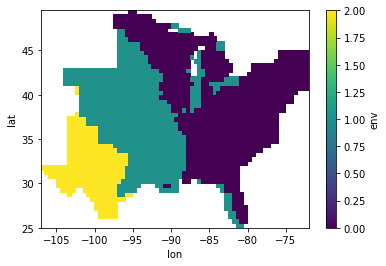

In [84]:
df_env.env[0:,0:].plot(yincrease=True, x='lon', y='lat')

In [37]:
#Create name for environments
X.loc[X.env == 2, 'env_name'] = "Mid"
X.loc[X.env == 1, 'env_name'] = "West"
X.loc[X.env == 0, 'env_name'] = "East"

In [38]:
X

rad40DAS    rad80DAS     radHarv   rain40DAS   rain80DAS  \
lat   lon                                                                  
25.25 -81.25  940.741821  892.229553  794.801208  235.732605  204.895905   
      -80.75  851.104553  830.807312  738.552246  284.264984  210.999130   
25.75 -81.75  962.600525  895.567871  799.576477  245.178665  240.116806   
      -81.25  923.276917  865.237183  774.140564  304.176910  261.682220   
      -80.75  824.786438  796.616089  711.153442  321.432739  259.580261   
...                  ...         ...         ...         ...         ...   
48.75 -93.75  823.937500  825.055298  614.686707  141.730225  119.244598   
      -93.25  821.462708  820.895142  613.326660  138.128433  119.297607   
      -92.75  822.718018  822.248901  615.610535  136.681198  125.872643   
49.25 -95.25  834.811157  836.851074  617.445740  135.285431  116.968925   
      -94.75  834.735596  835.574097  618.078125  131.501740  113.982758   

                rainHarv  temp40DAS  temp80DAS   tempHarv       biomass  env  \
lat   lon                                                                      
25.25 -81.25  252.141693  28.254566  29.002132  28.768867  19052.826172    2   
      -80.75  283.334900  27.710733  28.523867  28.350399  17342.443359    2   
25.75 -81.75  273.922211  28.151400  28.857300  28.719933  19231.335938    2   
      -81.25  293.346680  27.578701  28.500334  28.430401  18387.492188    2   
      -80.75  295.166138  27.422867  28.527866  28.438868  16668.882812    0   
...                  ...        ...        ...        ...           ...  ...   
48.75 -93.75  108.387856  15.587355  18.831127  16.361927   8365.384766    0   
      -93.25  106.424805  15.756723  19.013777  16.517223   8571.366211    0   
      -92.75  106.844795  15.437709  18.682146  16.420050   8331.594727    0   
49.25 -95.25   94.774231  15.715464  19.153627  16.579126   8894.783203    0   
      -94.75   96.422737  16.341486  19.805248  17.235380  10100.522461    0   

             env_name  
lat   lon              
25.25 -81.25      Mid  
      -80.75      Mid  
25.75 -81.75      Mid  
      -81.25      Mid  
      -80.75     East  
...               ...  
48.75 -93.75     East  
      -93.25     East  
      -92.75     East  
49.25 -95.25     East  
      -94.75     East  

[1860 rows x 12 columns]

In [13]:
1860*2*4*30

446400

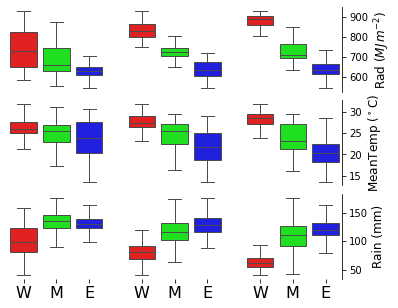

In [39]:
color_dict = dict({'East':'#0000fe','Mid':'#00ff01','West': '#ff0101'})

fig= plt.figure(figsize=(6,5))

plt.subplot(3, 3, 1)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="rad40DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

plt.subplot(3, 3, 2)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="rad80DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

plt.subplot(3, 3, 3)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="radHarv", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rad ($MJ\,m^{-2}$)', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

plt.subplot(3, 3, 4)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="temp40DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

plt.subplot(3, 3, 5)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="temp80DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

plt.subplot(3, 3, 6)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="tempHarv", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('MeanTemp ($^\circ$C)', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

plt.subplot(3, 3, 7)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="rain40DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, right=False)

pos   = [0,1,2]
label = ['W','M','E']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 8)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="rain80DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, right=False)

pos   = [0,1,2]
label = ['W','M','E']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 9)
ax=sns.boxplot(x="env_name", order=['West','Mid','East'], y="rainHarv", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rain (mm)', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

pos   = [0,1,2]
label = ['W','M','E']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplots_adjust(wspace=0.2, hspace=0.1)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs_clim.png', dpi=600,bbox_inches='tight')

hide_toggle()

<ipython-input-55-779512a174d9>:86: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


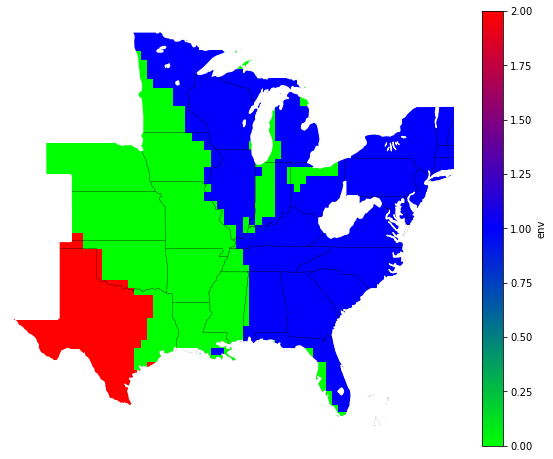

In [55]:
#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

colors = ['#00ff01','#0000fe','#ff0101']
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env.env.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=cm, add_colorbar=True, zorder=1, vmin=0, vmax=2)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
# cb = plt.colorbar(p, orientation="horizontal", pad=0.05, shrink=0.55, ticks=[0,1,2,3])
# cb.set_label(label='', size='xx-large', weight='bold', labelpad=50)
# cb.ax.tick_params(labelsize='x-large')
# cb.set_ticks([])

#fig.text(0.36, 0.19, 'HLL', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.49, 0.19, 'LHH', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.63, 0.19, 'MLM', va='center', rotation='horizontal', fontsize =17)
#fig.text(0.63, 0.19, 'MLM', va='center', rotation='horizontal', fontsize =17)

ax.outline_patch.set_visible(False)

# build and plot coordinates onto map
stations = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Python\all-stations.csv')
x = stations.lon
y = stations.lat
ax.scatter(stations.lon, stations.lat, marker='o', color='k', transform=ccrs.PlateCarree(),zorder=2, s=200)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\MAP.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [19]:
X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv.csv')

In [155]:
new2.columns

Index(['lat', 'lon', 'rad40DAS_x', 'rad80DAS_x', 'radHarv_x', 'rain40DAS_x',
       'rain80DAS_x', 'rainHarv_x', 'temp40DAS_x', 'temp80DAS_x', 'tempHarv_x',
       'biomass_x', 'env', 'env_name', 'irr', 'cultivar', 'time',
       'DaysAfterSowing', 'FloweringDAS', 'IrrigationIn', 'PAWC',
       'RadiationIn', 'RainIn', 'TempIn', 'aMaxT', 'aMinT', 'biomass_y',
       'planting_date', 'rad40DAS_y', 'rad80DAS_y', 'radHarv_y', 'rain40DAS_y',
       'rain80DAS_y', 'rainHarv_y', 'scen', 'sw_stress_expan', 'temp40DAS_y',
       'temp80DAS_y', 'tempHarv_y', 'irr_name', 'cv'],
      dtype='object')

In [41]:
#Merge dataframes to integrate the environment column with other variables
new2 = pd.merge(X, df0, how ='inner', on =['lat','lon']) 
#new2=new.drop(['RadiationIn_y','TempIn_y','RainIn_y','biomass_x'], axis=1)
new2.rename(columns={'biomass_y':'biomass'}, inplace=True)

#Change name of environments accordingly with levels of rad, rain and temp

new2.loc[new2.irr == 1, 'irr_name'] = "rainfed"
new2.loc[new2.irr == 2, 'irr_name'] = "irrigated"

new2.loc[new2.cultivar == 0, 'cv'] = "GS"
new2.loc[new2.cultivar == 1, 'cv'] = "SS"
new2.loc[new2.cultivar == 2, 'cv'] = "FSPS"
new2.loc[new2.cultivar == 3, 'cv'] = "FS"

<AxesSubplot:ylabel='Frequency'>

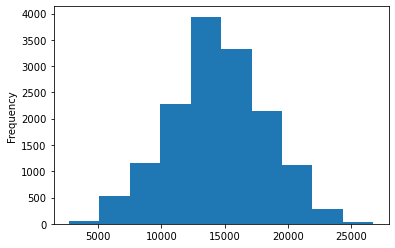

In [42]:
#Calculate means before the plot
mean=new2.groupby(['env_name','irr_name'])[['biomass']].mean().round(decimals=0)

a=new2.groupby(['env_name','irr_name','cultivar','lat','lon'])[['biomass']].mean().round(decimals=0)
a.biomass.plot.hist()

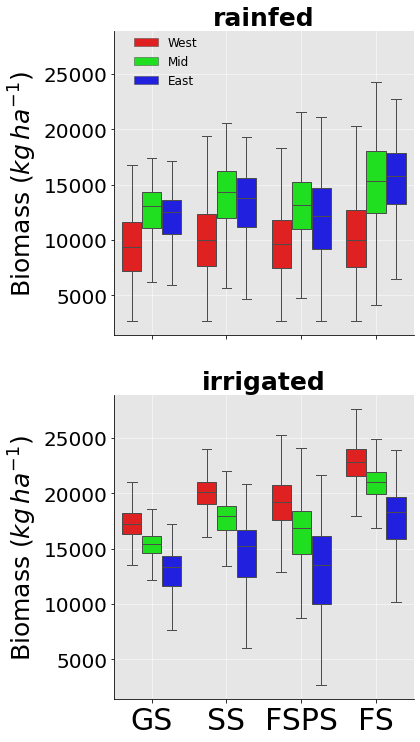

In [43]:
#Plot biomass by environment, cultivar and irrigation management
color_dict = dict({'East':'#0000fe','Mid':'#00ff01','West': '#ff0101'})

tkt_plot_detailed =sns.catplot(x="cv", order=['GS','SS','FSPS','FS'], y="biomass", data=new2, hue='env_name', 
                               hue_order=['West','Mid','East'], linewidth=1, kind='box', col='irr_name', 
                               col_wrap=1, legend=False, showfliers = False, palette=color_dict)

tkt_plot_detailed.set_axis_labels("", "Biomass ($kg\,ha^{-1}$)",fontsize= 25)
tkt_plot_detailed.set_titles(col_template="{col_name}", fontweight='bold', size=25)

for ax in tkt_plot_detailed.axes.flatten():

    ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
    ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
    ax.patch.set_facecolor('0.90')
    ax.set_axisbelow(True)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    pos   = [0, 1, 2, 3]
    label = ['GS','SS','FSPS','FS']
    ax.set_xticks(pos)
    ax.set_xticklabels(label)

plt.legend(prop=dict(size=12),bbox_to_anchor=(0.05, 2.2), loc=2, borderaxespad=0., frameon=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs.png', dpi=300,bbox_inches='tight')
hide_toggle()

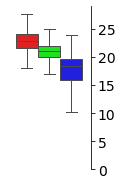

In [52]:
#Create subset of dataframes to create singular plots for biomass
new2['biomass2']=new2['biomass']/1000

rainfed = new2.where(new2['irr_name'] == 'rainfed')
irrigated = new2.where(new2['irr_name'] == 'irrigated')

GSd = rainfed.where(rainfed['cv'] == 'GS')
SSd = rainfed.where(rainfed['cv'] == 'SS')
FSPSd = rainfed.where(rainfed['cv'] == 'FSPS')
FSd = rainfed.where(rainfed['cv'] == 'FS')

GSi = irrigated.where(irrigated['cv'] == 'GS')
SSi = irrigated.where(irrigated['cv'] == 'SS')
FSPSi = irrigated.where(irrigated['cv'] == 'FSPS')
FSi = irrigated.where(irrigated['cv'] == 'FS')

#Plot biomass by environment, cultivar and irrigation management

fig = plt.figure(figsize=(1.5,3))
color_dict = dict({'East':'#0000fe','Mid':'#00ff01','West': '#ff0101'})
ax=sns.boxplot(x="cv", y="biomass2", data=FSi, hue='env_name', hue_order=['West','Mid','East'], linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =13)
plt.xlabel('', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_ylim([0,29])

fig.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\env1.png', dpi=300,bbox_inches='tight',transparent=True)

In [17]:
#Saving xarray as nc file
#df_env.to_netcdf(r"C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\env.nc")